data shape:  [[   0    0    0 ...   70 5804 3335]
 [   0    0    0 ...  670 1967  185]
 [   0    0    0 ... 8455  593   80]
 ...
 [   0    0    0 ...   15 6685 1676]
 [7553   34 1934 ...  578 2786 1619]
 [   0    0    0 ... 5023   76  575]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1851 samples, validate on 463 samples
Epoch 1/12
1851/1851 [==============================] - 14s 8ms/step - loss: 0.4051 - acc: 0.8314 - val_loss: 0.3474 - val_acc: 0.8510
Epoch 2/12
1851/1851 [==============================] - 13s 7ms/step - loss: 0.1617 - acc: 0.9400 - val_loss: 0.3487 - val_acc: 0.9136
Epoch 3/12
1851/1851 [==============================] - 13s 7ms/step - loss: 0.0774 - acc: 0.9827 - val_loss: 0.0468 - val_acc: 0.9914
Epoch 4/12
1851/1851 [==============================] - 14s 7ms/step - loss: 0.0257 - acc: 0.9935 - val_loss: 0.0397 - val_acc: 0.9892
Epoch 5/12
1851/1851 [==============================] - 14s 8ms/step - loss: 0.0156 - acc: 0.9946 - val_loss: 0.0281 - val_acc: 0.9914
Epoch 6/12
1851/1851 [==============================] - 14s 7ms/step - loss: 0.0055 - acc: 0.9995 - val_loss: 0.0414 - val_acc: 0.9892
Epoch 7/12
1851/1851 [==============================] - 14s 8ms/step - loss: 0.0047 - acc: 0.9989 - val_loss: 0.0466 - val_acc: 0.9892
Epoch 8/

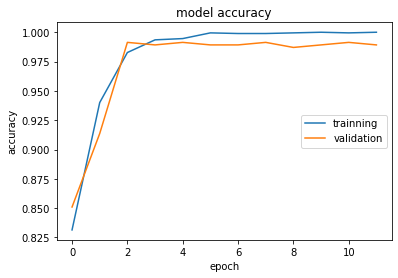

577/577 [==============================] - 1s 1ms/step
Test loss is 0.03 accuracy is 0.99  


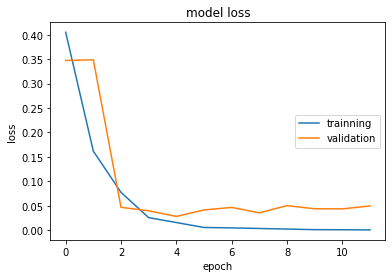

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, GRU, Dense, Flatten, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp

activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [1,5, 8, 10, 12, 15, 20, 25] 
batch_size = [30,60,100]

def main(rnn_model):
    def message_to_array(msg):
        msg = msg.lower().split(' ')
        test_seq = np.array([word_index[word] for word in msg])

        test_seq = np.pad(test_seq, (500-len(test_seq), 0), 'constant', constant_values=(0))
        test_seq = test_seq.reshape(1, 500)
        
        return test_seq

    data = pd.read_csv("drive/My Drive/Espamcode/lingspam.csv")
    

    messages = []
    labels = []
    for index, row in data.iterrows():
        messages.append(row['Message'])
        if row['Category'] == 0:
            labels.append(0)
        else:
            labels.append(1)

    messages = np.asarray(messages)
    labels = np.asarray(labels)

   # print("Number of messages: ", len(messages))
    #print("Number of labels: ", len(labels))

    max_vocab = 10000
    max_len = 500

    # Ignore all words except the 10000 most common words
    tokenizer = Tokenizer(num_words=max_vocab)
    # Calculate the frequency of words
    tokenizer.fit_on_texts(messages)
    # Convert array of messages to list of sequences of integers
    sequences = tokenizer.texts_to_sequences(messages)

    # Dict keeping track of words to integer index
    word_index = tokenizer.word_index

    # Convert the array of sequences(of integers) to 2D array with padding
    # maxlen specifies the maximum length of sequence (truncated if longer, padded if shorter)
    data = pad_sequences(sequences, maxlen=max_len)

    print("data shape: ", data)

    # We will use 80% of data for training & validation(80% train, 20% validation) and 20% for testing
    train_samples = int(len(messages)*0.8)
    
    messages_train = data[:train_samples]
    labels_train = labels[:train_samples]
     
    messages_test = data[train_samples:len(messages)-2]
    labels_test = labels[train_samples:len(messages)-2]
 
    

    embedding_mat_columns=40
    # Construct the SimpleRNN model
    model = Sequential()
    ## Add embedding layer to convert integer encoding to word embeddings(the model learns the
    ## embedding matrix during training), embedding matrix has max_vocab as no. of rows and chosen
    ## no. of columns 
    model.add(Embedding(input_dim=max_vocab, output_dim=embedding_mat_columns, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    
    if rnn_model == 'SimpleRNN':
        model.add(SimpleRNN(units=embedding_mat_columns))
    elif rnn_model == 'LSTM':
        #model.add(LSTM(units=embedding_mat_columns))
        model.add(Bidirectional(LSTM(units=embedding_mat_columns)))

    else:
        model.add(GRU(units=embedding_mat_columns))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

    #model.summary()
    #plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    # Training the model 
    history = model.fit(messages_train, labels_train, epochs=12, batch_size=60, validation_split=0.2)
    print(history.history.keys())
    plt.plot(history.history['acc'])

    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['trainning', 'validation'], loc='center right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['trainning', 'validation'], loc='center right')
    # plt.savefig('liang-loss.jpg')
    #files.download('liang-loss.jpg')
    #plt.show()
    # Testing the model
    pred = model.predict_classes(messages_test)
    acc = model.evaluate(messages_test, labels_test)
      
    print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))
    
# =============================================================================
#     print(pred)
#     print(labels_test)
# =============================================================================
    
    
    
    
    # Constructing a custom message to check model
# =============================================================================
#     custom_msg = 'Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed Free entry for movies'
#     test_seq = message_to_array(custom_msg)
#     pred = model.predict_classes(test_seq)
#     #print(pred)
# =============================================================================
if __name__ == '__main__':
    #main('SimpleRNN')
    main('LSTM')
    #main('GRU')

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [1,5, 8, 10, 12, 15, 20, 25] 
batch_size = [30,60,100]

def main(rnn_model):
    def message_to_array(msg):
        msg = msg.lower().split(' ')
        test_seq = np.array([word_index[word] for word in msg])

        test_seq = np.pad(test_seq, (500-len(test_seq), 0), 'constant', constant_values=(0))
        test_seq = test_seq.reshape(1, 500)
        
        return test_seq

    data = pd.read_csv("drive/My Drive/Espamcode/lingspam.csv")
    print(data.head())
    print(data.tail())

    messages = []
    labels = []
    for index, row in data.iterrows():
        messages.append(row['Message'])
        if row['Category'] == 0:
            labels.append(0)
        else:
            labels.append(1)
        

    messages = np.asarray(messages)
    labels = np.asarray(labels)

   # print("Number of messages: ", len(messages))
    #print("Number of labels: ", len(labels))

    max_vocab = 10000
    max_len = 500

    # Ignore all words except the 10000 most common words
    tokenizer = Tokenizer(num_words=max_vocab)
    # Calculate the frequency of words
    tokenizer.fit_on_texts(messages)
    # Convert array of messages to list of sequences of integers
    sequences = tokenizer.texts_to_sequences(messages)

    # Dict keeping track of words to integer index
    word_index = tokenizer.word_index

    # Convert the array of sequences(of integers) to 2D array with padding
    # maxlen specifies the maximum length of sequence (truncated if longer, padded if shorter)
    data = pad_sequences(sequences, maxlen=max_len)

    print("data shape: ", data.shape)

    # We will use 80% of data for training & validation(80% train, 20% validation) and 20% for testing
    train_samples = int(len(messages)*0.8)

    messages_train = data[:train_samples]
    labels_train = labels[:train_samples]

    messages_test = data[train_samples:len(messages)-2]
    labels_test = labels[train_samples:len(messages)-2]

    embedding_mat_columns=40
    # Construct the SimpleRNN model
    model = Sequential()
    ## Add embedding layer to convert integer encoding to word embeddings(the model learns the
    ## embedding matrix during training), embedding matrix has max_vocab as no. of rows and chosen
    ## no. of columns 
    model.add(Embedding(input_dim=max_vocab, output_dim=embedding_mat_columns, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    
    if rnn_model == 'SimpleRNN':
        model.add(SimpleRNN(units=embedding_mat_columns))
    elif rnn_model == 'LSTM':
        model.add(Bidirectional(LSTM(units=embedding_mat_columns)))
    else:
        model.add(GRU(units=embedding_mat_columns))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()

    #plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    # Training the model
    model.fit(messages_train, labels_train, epochs=2, batch_size=60, validation_split=0.2)
    # Testing the model
    pred = model.predict_classes(messages_test)
    acc = model.evaluate(messages_test, labels_test)
      
    print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))
    
# =============================================================================
#     print(pred)
#     print(labels_test)
# =============================================================================
    
    print("precision is about ", metrics.precision_score(labels_test, pred, average="macro"))
    print("recall is about ", metrics.recall_score(labels_test, pred, average="macro")) 
    print("f-score is about ", metrics.f1_score(labels_test, pred, average="macro"))
    print(metrics.confusion_matrix(labels_test, pred))
    
    
    # Constructing a custom message to check model
# =============================================================================
#     custom_msg = 'Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed Free entry for movies'
#     test_seq = message_to_array(custom_msg)
#     pred = model.predict_classes(test_seq)
#     #print(pred)
# =============================================================================

if __name__ == '__main__':
    #main('SimpleRNN')
    main('LSTM')
    #main('GRU')

   Category  ...                                            subject
0         0  ...            job posting - apple-iss research center
1         0  ...                                                NaN
2         0  ...  query : letter frequencies for text identifica...
3         0  ...                                               risk
4         0  ...                           request book information

[5 rows x 3 columns]
      Category  ...                                            subject
2888         1  ...                       love your profile - ysuolvpv
2889         1  ...                 you have been asked to join kiddin
2890         0  ...                 anglicization of composers ' names
2891         0  ...  re : 6 . 797 , comparative method : n - ary co...
2892         0  ...               re : american - english in australia

[5 rows x 3 columns]
data shape:  (2893, 500)
Model: "sequential_1"
_________________________________________________________________
Layer (ty

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1851 samples, validate on 463 samples
Epoch 1/1
577/577 [==============================] - 1s 1ms/step
Test loss is 0.33 accuracy is 0.91  
precision is about  0.9503745318352059
recall is about  0.7239583333333334
f-score is about  0.7832441436013751
[[481   0]
 [ 53  43]]


In [0]:
#!/usr/bin/env bash
set -e


LANG="bn"
WIKI_DIR="${LANG}wiki"
mkdir -p $WIKI_DIR
cd $WIKI_DIR

BASE_FILE="${LANG}wiki-latest-pages-articles.xml"
DUMP_FILE="${BASE_FILE}.bz2"
if [ ! -f $DUMP_FILE ]; then wget -c "https://dumps.wikimedia.org/${LANG}wiki/latest/${DUMP_FILE}"; fi
if [ ! -f $BASE_FILE ]; then bunzip2 $DUMP_FILE; fi
if [ ! -d wikiextractor ]; then git clone https://github.com/attardi/wikiextractor.git; fi

python wikiextractor/WikiExtractor.py --processes 4 --no_templates --min_text_length 1800 \
  --filter_disambig_pages --log_file log -b 100G -q $BASE_FILE

mv text/AA/wiki_00 $WIKI_DIR
rm -rf text
echo "Saving data in $WIKI_DIR"

SyntaxError: ignored